# Samuel's Models
I'll be building an Arima model for the following basins:
 - Grand Ronde, Powder Burnt, Imnaha
 - Henry's Fork, Teton, Willow, Blackfoot, Portneuf
 - Idaho Panhandle Region
 - Kootenai River In Montana
 - Lewis Cowlitz
 - Lower Clark Fork River Basin
 - Lower Columbia Hood River
 - Owyhee Malheur

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, train_test_split
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [111]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);

In [112]:
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [113]:
#a function to read in my csvs, set their index as a datetime object, and remove columns I already know I do not want
def data_formatter(filename):
    df = pd.read_csv(f'./basin_csvs/{filename}')
    df.set_index(pd.to_datetime(df['yyyymmdd']), inplace = True)
    df.drop(columns = ['Unnamed: 0', 'yyyymmdd', 'lat','long','station_id','elevation'],inplace = True)
    #remove dummy columns that we don't need after all
    df.drop(columns = df.columns[6:], inplace = True)
    return df

In [114]:
grand_ronde_df = data_formatter('grand_ronde_powder_burnt_imnaha.csv')
henrys_fork_df = data_formatter('henrys_fork_teton_willow_blackfoot_portneuf.csv')
idaho_panhandle_df = data_formatter('idaho_panhandle_region.csv')
kootenai_river_df = data_formatter('kootenai_river_in_montana.csv')
lewis_cowlitz_df = data_formatter('lewis_cowlitz.csv')
lower_clark_df = data_formatter('lower_clark_fork_river_basin.csv')
lower_columbia_df = data_formatter('lower_columbia_hood_river.csv')
owyhee_malheur_df = data_formatter('owyhee_malheur.csv')


In [115]:
grand_ronde_df.shape

(351, 6)

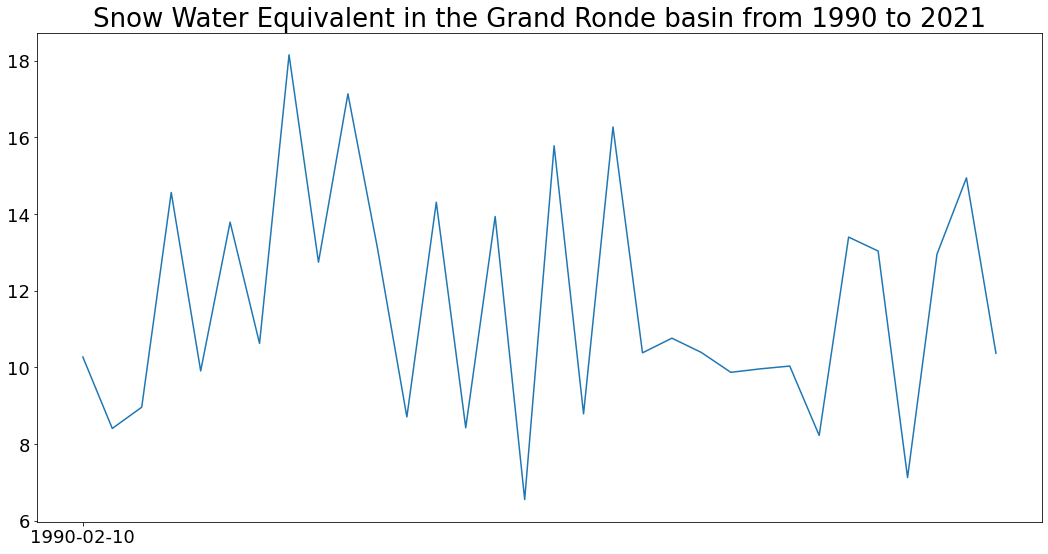

In [116]:
#taking a look at an example time series plot of the Grand Ronde basin group
plot_series(grand_ronde_df.groupby('yyyymmdd').mean(), cols=['wteq_amt'], title='Snow Water Equivalent in the Grand Ronde basin from 1990 to 2021', steps=32)

In [117]:
#groups all the different observations by different stations in each basin by date, and averages them
def basin_grouper(basin_df):
    df = pd.DataFrame(basin_df.groupby('yyyymmdd').mean())
    return df.asfreq(pd.DateOffset(years=1))

In [118]:
grand_group_df = basin_grouper(grand_ronde_df)
henry_group_df = basin_grouper(henrys_fork_df)
idaho_group_df = basin_grouper(idaho_panhandle_df)
kootenai_group_df = basin_grouper(kootenai_river_df)
lewis_group_df = basin_grouper(lewis_cowlitz_df)
clark_group_df = basin_grouper(lower_clark_df)
columbia_group_df = basin_grouper(lower_columbia_df)
owyhee_group_df = basin_grouper(owyhee_malheur_df)
#a list to use later
grouped_list = [grand_group_df,
henry_group_df,
idaho_group_df,
kootenai_group_df,
lewis_group_df,
clark_group_df,
columbia_group_df,
owyhee_group_df]

## Examining adfuller tests to look for stationarity.

In [119]:
interpret_dftest(adfuller(grand_group_df['wteq_amt']))
#fairly unstationary to begin with

Test Statistic   -7.315623e+00
p-value           1.231519e-10
dtype: float64

In [120]:
interpret_dftest(adfuller(henry_group_df['wteq_amt']))

Test Statistic   -1.875563
p-value           0.343643
dtype: float64

In [121]:
interpret_dftest(adfuller(idaho_group_df['wteq_amt']))

Test Statistic   -6.637471e+00
p-value           5.516138e-09
dtype: float64

In [122]:
interpret_dftest(adfuller(kootenai_group_df['wteq_amt']))

Test Statistic   -6.580917e+00
p-value           7.518268e-09
dtype: float64

In [123]:
interpret_dftest(adfuller(clark_group_df['wteq_amt']))

Test Statistic   -6.642518e+00
p-value           5.365469e-09
dtype: float64

In [124]:
interpret_dftest(adfuller(columbia_group_df['wteq_amt']))

Test Statistic   -6.554637e+00
p-value           8.677971e-09
dtype: float64

In [125]:
interpret_dftest(adfuller(owyhee_group_df['wteq_amt']))

Test Statistic   -7.034230e+00
p-value           6.074418e-10
dtype: float64

It seems that most of our data here is stationary by default, and so diffing may not be useful.  I'll include it in my gridsearch later, however.

# Feature Engineering

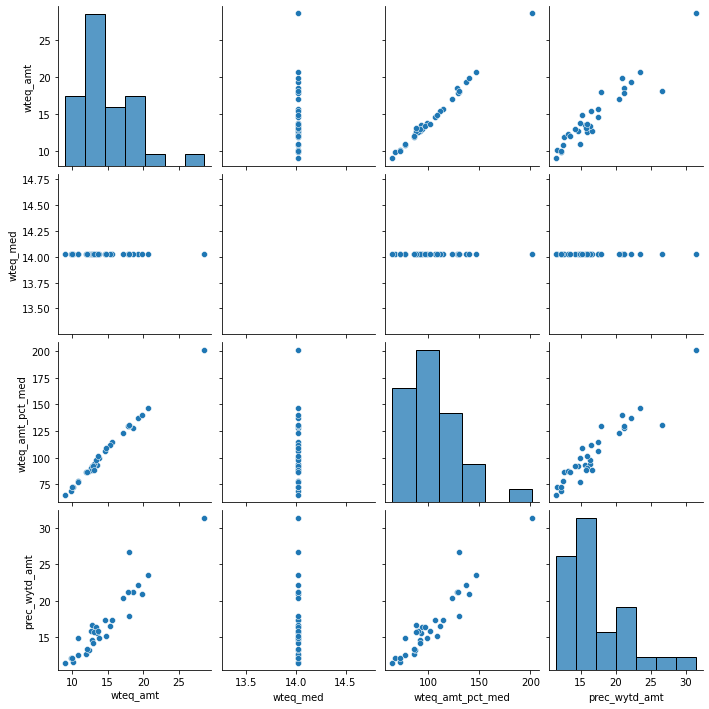

In [126]:
sns.pairplot(henry_group_df);

Looking at this one pairplot shows a clear relationship between the year-to-date amount (prec-wytd-amt) and the amount observed (wteq_amt).  I also have decided to drop the median columns, as I am unlikely to have those points of data in a real-world prediction situation.  I will, however, possess how much rain has fallen up til the current date.

In [127]:
for df in grouped_list:
   df.drop(columns = ['wteq_amt_pct_med', 'wteq_med'], inplace = True)

In [128]:
#checking to see the above for loop worked
grand_group_df.head()

,wteq_amt,prec_wytd_amt
yyyymmdd,,
1990-02-10,10.272727,14.027273
1991-02-10,8.409091,13.254545
1992-02-10,8.963636,13.654545
1993-02-10,14.563636,17.563636
1994-02-10,9.909091,11.936364


# Modeling Time

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblep

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,0).
This model has an AIC of 116.60542655551077.


/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


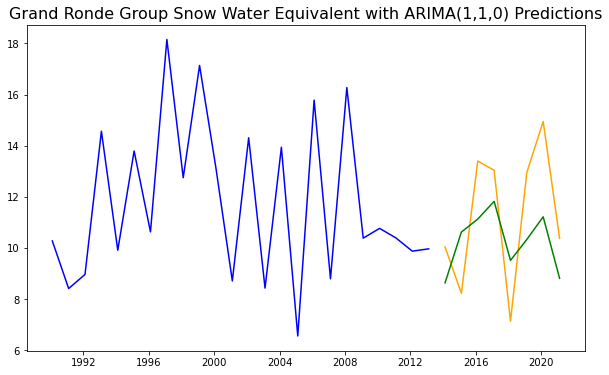

In [129]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = grand_group_df.drop(columns = 'wteq_amt')
y = grand_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
        
            # Insert try and except statements.
            try:

                

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))


                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q


            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'prediction')

plt.title(label = f'Grand Ronde Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblep

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/



MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,3).
This model has an AIC of 136.15850849063168.


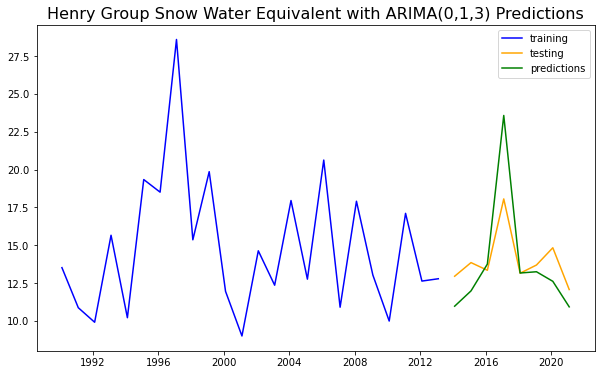

In [130]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = henry_group_df.drop(columns = 'wteq_amt')
y = henry_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
        
            # Insert try and except statements.
            try:

                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))


                # Fit ARIMA model.
                model = arima.fit()

                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q


            except:
                pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')

plt.title(label = f'Henry Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblep

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 159.27881389897635.


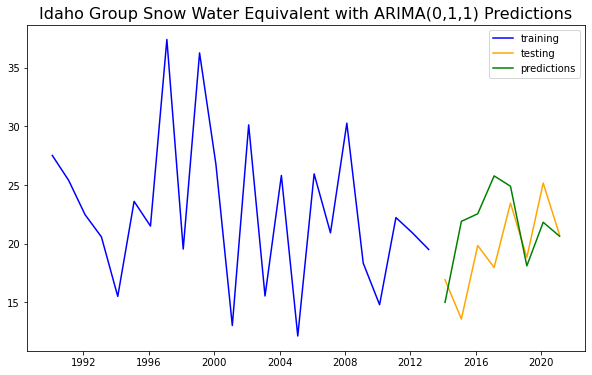

In [137]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = idaho_group_df.drop(columns = 'wteq_amt')
y = idaho_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Idaho Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive p

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 143.34903207552736.


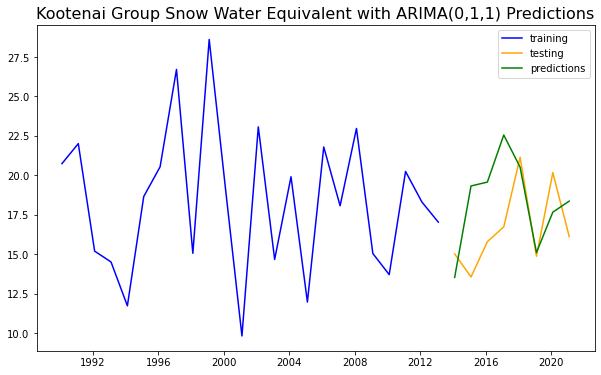

In [141]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = kootenai_group_df.drop(columns = 'wteq_amt')
y = kootenai_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Kootenai Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblep

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,0,1).
This model has an AIC of 180.9251981899779.


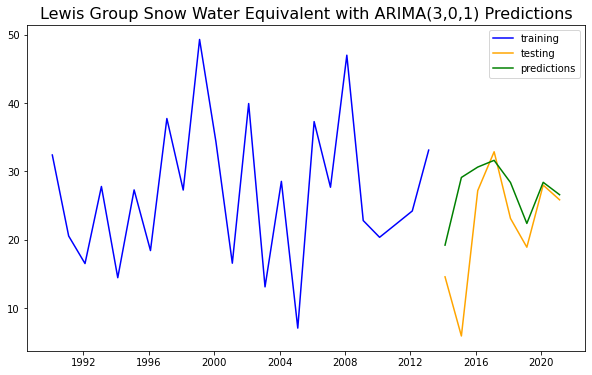

In [142]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = lewis_group_df.drop(columns = 'wteq_amt')
y = lewis_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Lewis Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive p

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,4,2).
This model has an AIC of 12.0.


/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


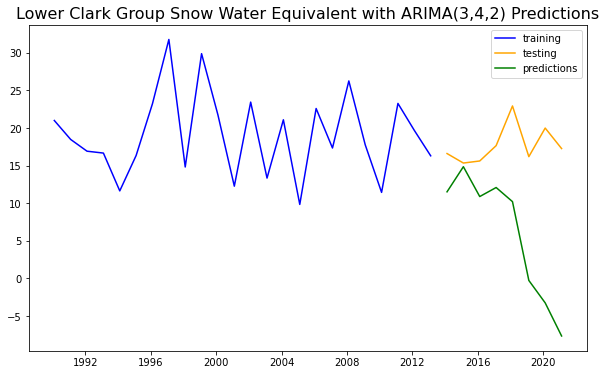

In [143]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = clark_group_df.drop(columns = 'wteq_amt')
y = clark_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Lower Clark Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive p

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 173.78651315665007.


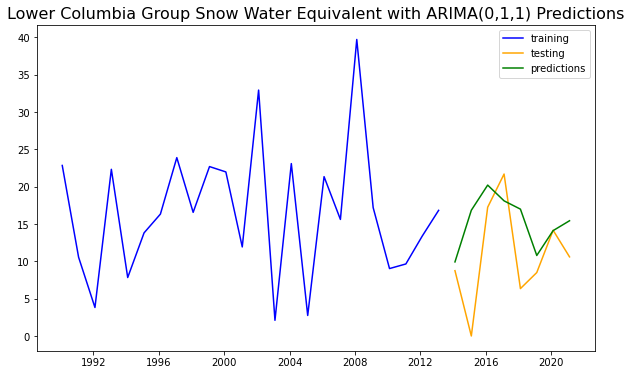

In [139]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = columbia_group_df.drop(columns = 'wteq_amt')
y = columbia_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Lower Columbia Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblepatch/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bramblep

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(2,1,1).
This model has an AIC of 117.9443716300546.


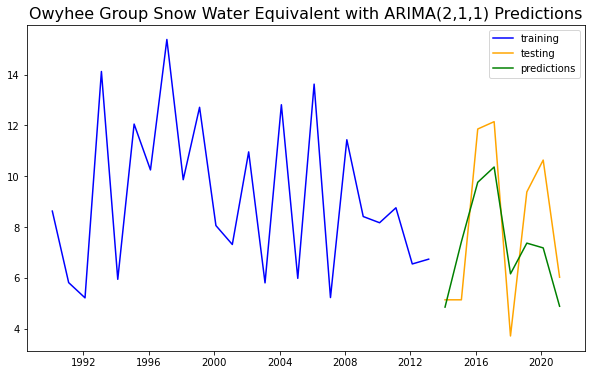

In [140]:
#code taken from ARIMA lesson, modified to include d as a parameter
X = owyhee_group_df.drop(columns = 'wteq_amt')
y = owyhee_group_df['wteq_amt']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = False)
# Starting AIC, p, d, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
best_d = 0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for d in range(5):
        for q in range(5):
            # Insert try and except statements.
            try:
                # Instantiate ARIMA model.
                arima = ARIMA(endog=y_train, order=(p, d, q))
                # Fit ARIMA model.
                model = arima.fit()
                # Is my current model's AIC better than our best_aic?
                if model.aic < best_aic:

                    # If so, let's overwrite best_aic, best_p, and best_q.
                    best_aic = model.aic
                    best_p = p
                    best_d = d
                    best_q = q
            except:
                pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},{best_d},{best_q}).')
print(f'This model has an AIC of {best_aic}.')
model = ARIMA(endog = y_train, exog = X_train, order = (best_p, best_d, best_q))
arima = model.fit()
preds = arima.predict(start=y_test.index[0], end = y_test.index[-1], exog = X_test )
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue', label = 'training')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test), color = 'orange', label = 'testing')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label = 'predictions')
plt.title(label = f'Owyhee Group Snow Water Equivalent with ARIMA({best_p},{best_d},{best_q}) Predictions', fontsize=16)
plt.legend()
plt.show();

Ultimately, our models perform pretty decently!  They are not precise across every basin, and our Clark group model particularly fails, but for a ballpark prediction, this could very well serve.  